In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SR_F_HZ = 1000
SQ_WAVE_F_HZ = 10

data = pd.read_csv('out/output.csv')
data = data[000:]
for label in ('Data', 'Reference'):
    data[label] -= data[label][:(SR_F_HZ//SQ_WAVE_F_HZ//2)].min()  # OG Data contains values < 0.
    data[label] /= data[label][:(SR_F_HZ//SQ_WAVE_F_HZ//2)].max()
data = data.tail(-data[data['Data'].diff().gt(0.1)].index[0]+1).reset_index(drop=True)
data['Time'] = np.arange(len(data)) / SR_F_HZ


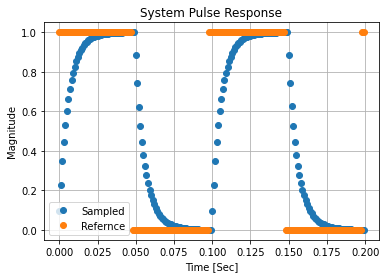

In [3]:
plt.plot(data['Time'][:200], data['Data'][:200], 'o', label='Sampled')
plt.plot(data['Time'][:200], data['Reference'][:200], 'o', label='Refernce')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()
plt.grid()

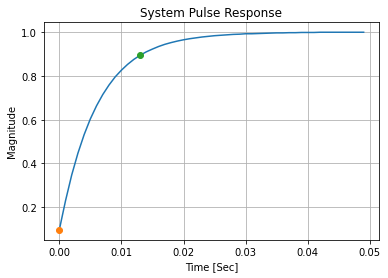

In [4]:
v10 = (data['Data'].max())*.1
v90 = (data['Data'].max())*.9

t10_i = (data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)] - v10).abs().argmin()
t90_i = (data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)] - v90).abs().argmin()

plt.plot(data['Time'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)])
plt.plot(data['Time'][t10_i], data['Data'][t10_i], 'o')
plt.plot(data['Time'][t90_i], data['Data'][t90_i], 'o')
plt.title('System Pulse Response')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.grid()

In [5]:
tr = abs(data['Time'][t90_i] - data['Time'][t10_i])
print(f't_r = {tr * 1000} ms')

t_r = 13.0 ms


In [6]:
## White Box Analysis
c_1 = 100e-9
c_2 = 200e-9
r_1 = 10e3
r_2 = 10e3

p1 = 1/(2 * np.pi * c_1 * r_1)
p2 = 1/(2 * np.pi * c_2 * r_2)

print(f'Pole frequencies: {p1}Hz, {p2}Hz')

Pole frequencies: 159.15494309189532Hz, 79.57747154594766Hz


In [7]:
import numpy as np
from scipy.linalg import expm
from control import *
import matplotlib.pyplot as plt

s = tf('s')
hs_1 = 1 / ((r_1*c_1*r_2*c_2)*s*s + (r_1*c_1+r_1*c_2+r_2*c_2)*s + 1)
num_1, den_1 = tfdata(hs_1)



   0.1223 z + 0.05442
------------------------
z^2 - 0.9053 z + 0.08208

dt = 0.001

[[array([0.12232086, 0.05441719])]]
[[array([ 1.        , -0.90534694,  0.082085  ])]]


(array([0.80314212+0.j, 0.10220482+0.j]), array([-0.44487251+0.j]))

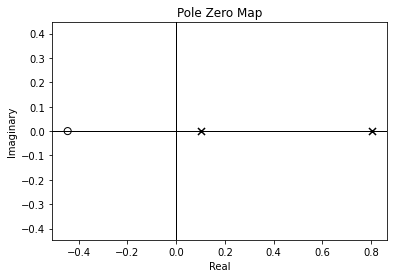

In [70]:
hz_1 = c2d(hs_1, 1/SR_F_HZ, 'zoh')
numz_1, denz_1 = tfdata(hz_1)
ss_2 = tf2ss(numz_1, denz_1)
print(hz_1)
print(numz_1)
print(denz_1)
pzmap(hz_1)

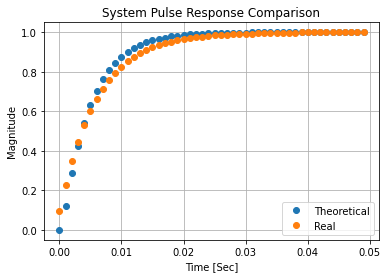

In [9]:
t, hz_out = step_response(hz_1)
plt.plot(t[:SR_F_HZ//SQ_WAVE_F_HZ//2], hz_out[:SR_F_HZ//SQ_WAVE_F_HZ//2], 'o', label='Theoretical')
plt.plot(data['Time'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], data['Data'][:(SR_F_HZ//SQ_WAVE_F_HZ//2)], 'o', label='Real')
plt.grid()
plt.title('System Pulse Response Comparison')
plt.ylabel('Magnitude')
plt.xlabel('Time [Sec]')
plt.legend()

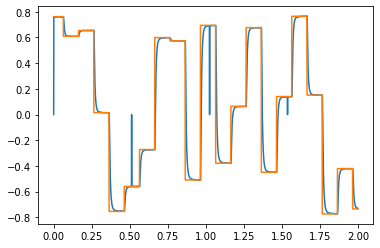

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

SR_F_HZ = 1000
SQ_WAVE_F_HZ = 10

data = pd.read_csv('out/prbs_resp.csv')
data['Time'] = np.arange(len(data)) / SR_F_HZ
plt.plot(data[:2000]['Time'], data[:2000]['Data'])
plt.plot(data[:2000]['Time'], data[:2000]['Reference'])

In [138]:
import numpy as np

order = 2

def identificacionRLS(n, u, y, lastP, lastTheta):
    Phi = np.asmatrix(np.concatenate((y[::-1][1:n+1], u[::-1][:n+1])))
    p = lastP - np.dot(np.dot(lastP, Phi.T), Phi.dot(lastP))/(1 + np.dot(np.dot(Phi, lastP), Phi.T))
    k = np.dot(lastP, Phi.T)/(1 + np.dot(np.dot(Phi, lastP), Phi.T))
    error = (np.asmatrix(y[-1]) - np.dot(Phi, lastTheta))[0, 0]
    aux = error * k 
    theta = lastTheta + np.asmatrix(aux)
    return theta, p, error 

Theta = np.zeros((2*order+1, 1))
print(Theta)
P = np.eye(2*order+1)

toterr = []
for i in range(order, len(data['Data'])):
    Theta, P, error = identificacionRLS(order, np.array(data['Reference'][i-order:i+1]), np.array(data['Data'][i-order:i+1]), P, Theta)
    toterr.append(error)


[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


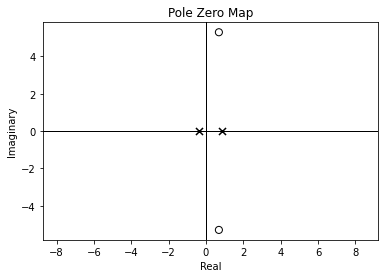

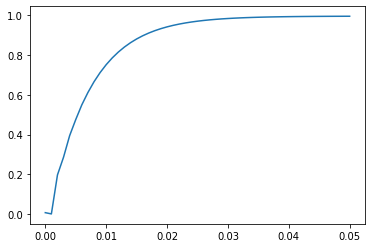

In [139]:
num = np.array(Theta[order:].flatten()) 
den = [1, float(-Theta[0]), float(-Theta[1])]
ss_rls = tf2ss(tf(np.array(num)[0], [[np.array(den)]], dt=1/SR_F_HZ)) 
pzmap(ss_rls)
plt.show()

t, hz_out = step_response(ss_rls, T=0.05)

plt.plot(t, hz_out)

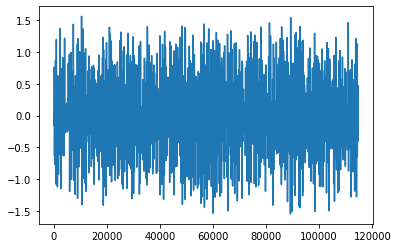

In [107]:
plt.plot(toterr)

array([-0.00022017,  0.00107123, -0.00094862])

In [116]:
a = [1, 2, 3, 4]
b = [5, 6, 7, 8]
n = 2
np.asmatrix(np.concatenate((a[::-1][1:n+1], b[::-1][:n+1])))

matrix([[3, 2, 8, 7, 6]])